Simple DQN for Space Invaders
==============================

We will train a simple DQN for the SpaceInvaders environment of openAI gym.
First, let's import some packages.

In [1]:
# load required packages
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


# create the environment
env = gym.make('SpaceInvaders-v0').unwrapped
actionsDim = 6 # number of actions for this environment

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-01-05 10:55:30,095] Making new env: SpaceInvaders-v0


Replay Memory
---------------------

The first thing we will need to train our DQN is a so-called replay memory.
This is a buffer that stores the states, actions and rewards our agent experiences
as it interacts with the environment. By sampling data from this memory, we can
create the batches we need to train our model. The sampling must be random, otherwise
our data will be correlated, and the performance would decrease.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

DQN model
-------------

The name DQN stands for "Deep Q Network". It is a network that tries to learn the so-called $Q$ function of our environment. The Q function, $Q^\pi(s,a)$, gives us the expected total reward, when we are in state $s$, do action $a$, and then follow policy $\pi$ afterwards.<br>
From RL, it can be shown that the $Q^*$ function of the optimal (best) policy we are looking for, will satisfy the following equation:

\begin{align}Q^*(s,a) = r + \gamma \max_a Q^*(s',a)\end{align}

The difference between the two sides is called $\delta$. The goal of our network is to minimize it, in order to determine the optimal Q function, with which, we can then determining the optimal policy, by finding the action that maximizes the Q function of a given state.<br>
To train the network, we use the Huber loss, which has been shown to be more robust against noisy samples that the simple quadratic loss. The data we will use will come from the replay memory.<br>
For the model, we use a CNN, so that we can feed the image directly as a state to the network. We use three conv layers with batchnorm, together with a final linear layer to compute the scores. The output is the Q function of the input state, for all possible actions.

In [3]:
# define the model we will be using
        
class DQN(nn.Module):

    def __init__(self, input_dim = (3,50,50), kernel_size = 5, stride = 2, pad = 0, num_classes = actionsDim):
        # a simple dqn network. We use three conv layers with batch norm,
        # and a final linear layer (we don't need softmax). The outputs
        # will be the Q funtion for each possible action. We use 16 and
        # 32 filters, with kernel size 5 and stride 2.
        super(DQN, self).__init__()
        # get input dims
        C, H, W = input_dim
        # layer 1: conv layer
        self.conv1 = nn.Conv2d(C, 16, kernel_size=kernel_size, stride=stride, padding = (pad,pad))
        self.bn1 = nn.BatchNorm2d(16)
        # update params
        H = int((H + 2*pad - kernel_size) / stride + 1)
        W = int((W + 2*pad - kernel_size) / stride + 1)
        C = 16
        # layer 2: conv
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding = (pad,pad))
        self.bn2 = nn.BatchNorm2d(32)
        # update params
        H = int((H + 2*pad - kernel_size) / stride + 1)
        W = int((W + 2*pad - kernel_size) / stride + 1)
        C = 32
        # layer 3: conv
        self.conv3 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding = (pad,pad))
        self.bn3 = nn.BatchNorm2d(32)
        # update params
        H = int((H + 2*pad - kernel_size) / stride + 1)
        W = int((W + 2*pad - kernel_size) / stride + 1)
        C = 32
        # layer 4: linear     
        self.head = nn.Linear(H*W*C, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Extracting the Input
-----------------------------------------
To train the network, we must be able to extract snapshots from the environment. We do that with the following function, which gets a snapshot from gym, transforms it to a square image of given size, and then to a pytorch tensor.

In [4]:
# Input extraction
        
# Define an image transformation
myTransform = T.Compose([T.ToPILImage(),
                    T.Resize([50,50], interpolation=Image.CUBIC),
                    #T.Grayscale(),
                    T.ToTensor()])
    
# a function to grab an image from the environment
def get_screen():
    # take a snapshot and transpose into torch order (CHW)    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Convert to float, risize, grayscale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return myTransform(screen).unsqueeze(0).type(Tensor)

Hyperparameters, etc.
-------------------------------------
In this section, we define the hyperparameters for our model, and a policy function, that uses the model to find the next action, given the state. We use an e-greedy policy, with $\epsilon$ decaying to zero exponentially.

In [5]:
# hyperparams and other utilities
    
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
# path to save model weiths
PATH = 'myModel_SpaceInv'

# build the model
model = DQN()

if use_cuda:
    model.cuda()
    
# load pretrained weights, if they exist
try:
    model.load_state_dict(torch.load(PATH))
    print('Pretrained weights loaded')
except:
    print('No pretrained weights avaiable, or weights dont match')

# build the optimizer
optimizer = optim.RMSprop(model.parameters())
# initialize the replay memory
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    # selects an action based on an e-greedy policy
    # epsilon decays exponentionally towards zero, so that our
    # policy becomes greedy as time passes
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(actionsDim)]])


episode_durations = []

Pretrained weights loaded


Model Optimizer
-----------------------------
This function optimizes our model, by computing the Huber loss and then backporpagating. Notice that we need to compute two network outputs (for the current state and the next - expected state) to calculate the Huber loss.

In [6]:
# function to train the model
        
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # get a batch from replay memory
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
    # extract states, actions and rewards in the batch
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    # Compute Q(s_t, a) - the model computes Q(s_t) for all actions,
    # then we select the columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute a mask of non-final states
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # get the next states that are not final states (None)
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)

    # Compute max Q(s',a) for all non-final next states (rest are zeros)
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # set volatile to false, so that we don't backprop through the next
    # states (the DQN's inputs are the current states-actions)
    next_state_values.volatile = False
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        # gradient clipping
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Train
------------------------------
We run episodes with the environment to train the model. Until each episode finishes, we store the transitions in the replay memory, and use them for training. We do a batch training step after each time-step, and not all together after the episode. This could improve performance.

Episode no. 0, duration: 510
Episode no. 1, duration: 679
Complete


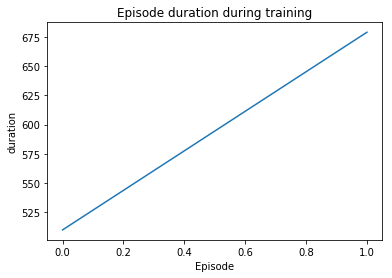

In [7]:
# run some episodes and train the model!
    
num_episodes = 2 # in reality, this must be thousands!
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    # the state is the difference image between current and prev screens
    # this trick captures also the velocities of various objects
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        # we optimize the network in place, not after the episodes
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            print('Episode no. ' + str(i_episode)+', duration: ' + str(t+1))
            break

print('Complete')
plt.plot(list(range(len(episode_durations))), episode_durations)
plt.xlabel('Episode')
plt.ylabel('duration')
plt.title('Episode duration during training')
plt.show()
# store weights
torch.save(model.state_dict(), PATH)

Simulation
------------------------------
Finally, we run one episode with the trained model live on the gym environment to see what it learned.

In [8]:
# run trained model on a sample episode

done = False
t = 0 
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
while not done:
    env.render()
    t += 1
    last_screen = get_screen()
    # Select and perform an action
    action = select_action(state)
    _, reward, done, _ = env.step(action[0, 0])
    reward = Tensor([reward])

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # Move to the next state
    state = next_state
# we're done
input('Press any key to close program...')
env.render(close=True)
env.close()
print('The duration of this episode was: ' + str(t))   

Press any key to close program...
The duration of this episode was: 663
